In [143]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import pandas as pd
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline



In [144]:
iris = sklearn.datasets.load_iris()

print(type(iris))

<class 'sklearn.utils._bunch.Bunch'>


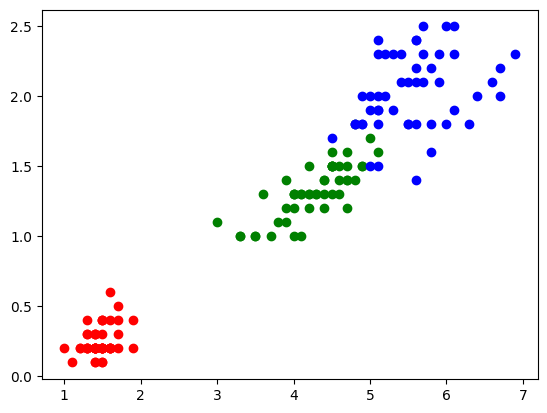

In [145]:
features = iris.data
labels = iris.target

plt.figure()
plt.scatter(features[labels == 0,2], features[labels == 0, 3], c = 'r', label = 'Setosa')
plt.scatter(features[labels == 1,2], features[labels == 1, 3], c = 'g', label = 'Versicolor')
plt.scatter(features[labels == 2,2], features[labels == 2, 3], c = 'b', label = 'Virginica')
plt.show()

# # Visualizing only classes green and blue in 3d (in the first three features)
# custom_colors = ['g', 'b']
# cmap_custom = matplotlib.colors.ListedColormap(custom_colors)
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(features[labels != 0,1], features[labels != 0,2], features[labels != 0,3], c = labels[labels != 0], cmap = cmap_custom)
# plt.show()

In [146]:
# Saving only the green and blue classes with features 2, and 3
features = iris.data
labels = iris.target

features = features[labels != 0] # Drop class 0
features = features[:,2:] # Drop features 0 and 1

labels = labels[labels != 0] # Drop class 0

In [147]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(features, labels, train_size=0.80)

print(train.shape)
print(test.shape)
print(labels_train.reshape(-1,1).shape)
print(labels_test.reshape(-1,1).shape)

train = torch.from_numpy(train)
test = torch.from_numpy(test)
labels_train = torch.from_numpy(labels_train).reshape(-1,1)
labels_test = torch.from_numpy(labels_test).reshape(-1,1)

print(train.shape)
print(test.shape)
print(labels_train.shape)
print(labels_test.shape)

labels_train = labels_train.remainder(2) # 'Relabels' class 2 as class 0 --> Now we have classes 0 and 1
labels_test = labels_test.remainder(2) # 'Relabels' class 2 as class 0 --> Now we have classes 0 and 1

print(labels_train[:5])
print(labels_test[:5])

# Since we removed one class and on feature we need to
# make some manual adjustments to the feature and target names 
feature_names = iris.feature_names[2:]
target_names = iris.target_names[1:][::-1]


(80, 2)
(20, 2)
(80, 1)
(20, 1)
torch.Size([80, 2])
torch.Size([20, 2])
torch.Size([80, 1])
torch.Size([20, 1])
tensor([[1],
        [0],
        [0],
        [0],
        [1]])
tensor([[0],
        [0],
        [1],
        [0],
        [0]])


In [148]:
# rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

class LogisticRegressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
    def class_probabilities(self, x):
        with torch.no_grad():
            x = self.forward(x)
            class_probs = torch.cat((1-x, x), dim = 1)
        return class_probs.reshape(-1,2)
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            predicted_class = x.detach().round()
        return predicted_class.reshape(-1,1)

model = LogisticRegressor(2,1)

In [149]:
# rf.fit(train, labels_train)

# Hyperparameters
lr = 0.05
num_epochs = 500

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

train = train.float()
test = test.float()
labels_train = labels_train.float()
labels_test = labels_test.float()

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    optimizer.zero_grad()
    outputs = model.forward(train)
    loss = loss_fn(outputs, labels_train)
    loss.backward()
    optimizer.step()
    
    # Calculate training and validation accuracy every epoch
    training_accuracy = 0
    test_accuracy = 0
     
    model.eval()
    outputs = model.predict(train)
    training_accuracy = (outputs == labels_train).float().mean()
    outputs = model.predict(test)
    test_accuracy = (outputs == labels_test).float().mean()
    #print('Training accuracy = {} | Test accuracy = {}'.format(training_accuracy, test_accuracy))
    
    # Print the loss every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}' + ' Training accuracy = {} | Test accuracy = {}'.format(training_accuracy, test_accuracy))
        
print('Done!')

Epoch [1/500], Loss: 1.4920772314071655 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [2/500], Loss: 1.338945984840393 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [3/500], Loss: 1.1945255994796753 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [4/500], Loss: 1.0622446537017822 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [5/500], Loss: 0.9464088678359985 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [6/500], Loss: 0.8519154787063599 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [7/500], Loss: 0.7834013104438782 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [8/500], Loss: 0.7436782121658325 Training accuracy = 0.3375000059604645 | Test accuracy = 0.550000011920929
Epoch [9/500], Loss: 0.7318381071090698 Training accuracy = 0.400000005960

Epoch [40/500], Loss: 0.6858929991722107 Training accuracy = 0.574999988079071 | Test accuracy = 0.550000011920929
Epoch [41/500], Loss: 0.6854991912841797 Training accuracy = 0.6499999761581421 | Test accuracy = 0.6000000238418579
Epoch [42/500], Loss: 0.6846330165863037 Training accuracy = 0.6625000238418579 | Test accuracy = 0.6499999761581421
Epoch [43/500], Loss: 0.6830731630325317 Training accuracy = 0.675000011920929 | Test accuracy = 0.6499999761581421
Epoch [44/500], Loss: 0.6807901263237 Training accuracy = 0.6625000238418579 | Test accuracy = 0.6000000238418579
Epoch [45/500], Loss: 0.6779218912124634 Training accuracy = 0.6625000238418579 | Test accuracy = 0.75
Epoch [46/500], Loss: 0.6747163534164429 Training accuracy = 0.737500011920929 | Test accuracy = 0.75
Epoch [47/500], Loss: 0.6714585423469543 Training accuracy = 0.625 | Test accuracy = 0.75
Epoch [48/500], Loss: 0.6684011220932007 Training accuracy = 0.5874999761581421 | Test accuracy = 0.800000011920929
Epoch [49/

In [150]:
# sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

sklearn.metrics.accuracy_score(labels_test, model.predict(test))

0.9

In [203]:

explainer = lime.lime_tabular.LimeTabularExplainer(train.numpy(),
                                                   feature_names=feature_names,
                                                   class_names=target_names,
                                                   discretize_continuous=False,
                                                   sample_around_instance=True)

# Create funcction to pass to explainer.explain_instance
apply_model_predict = lambda x: model.class_probabilities(torch.from_numpy(x).float()).numpy()

In [204]:
# Select an instance to explain
i_explained = np.random.randint(0, test.shape[0])

exp = explainer.explain_instance(test[i_explained].numpy(), apply_model_predict, num_features=2)

In [205]:
# Extract coefficients of LIME explanation
coefficients_map = exp.local_exp[1]
feature_index = [elem[0] for elem in coefficients_map]
LIME_coefficients = [coefficients_map[i][1] for i in feature_index]
LIME_intercept = exp.intercept[1]


# Compute the rescaled LIME coefficients
# See https://github.com/marcotcr/lime/issues/113
beta0 = LIME_intercept
beta1 = LIME_coefficients[0]
beta2 = LIME_coefficients[1]

mu1 = explainer.scaler.mean_[0]
mu2 = explainer.scaler.mean_[1]

sigma1 = explainer.scaler.scale_[0]
sigma2 = explainer.scaler.scale_[1]

beta0_rescaled = beta0 - beta1*mu1/sigma1 - beta2*mu2/sigma2
beta1_rescaled = beta1/sigma1
beta2_rescaled = beta2/sigma2

# Create decision boundary
decision_boundary_LIME = lambda x : (0.5-beta0_rescaled)/beta2_rescaled - x*beta1_rescaled/beta2_rescaled

In [206]:
# Extract coefficients of original model and create decision boundary
coefficients = model.linear.weight.detach().numpy()
biases = model.linear.bias.detach().numpy()
decision_boundary = lambda x : (-biases)/coefficients[0][1] - x*coefficients[0][0]/coefficients[0][1]

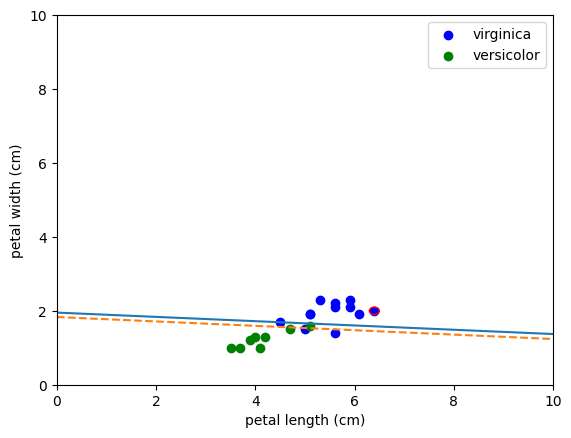

In [207]:
x = np.linspace(0, 10, 100)
y = decision_boundary(x)
y_LIME = decision_boundary_LIME(x)

features_test = test.numpy() if not isinstance(test, np.ndarray) else test
labels_test = labels_test.numpy() if not isinstance(labels_test, np.ndarray) else labels_test

# Plotting the decision boundary and the test set
plt.plot(x, y)
plt.plot(x, y_LIME, linestyle = '--')
ix0 = (labels_test == 0).ravel()
ix1 = (labels_test == 1).ravel()
plt.scatter(features_test[ix0,0], features_test[ix0, 1], c = 'b', label = target_names[0])
plt.scatter(features_test[ix1,0], features_test[ix1, 1], c = 'g', label = target_names[1])
point_explained = features_test[i_explained,:]
circle = plt.Circle(point_explained, 0.1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()

In [208]:
# Print LIME coefficients
print("LIME_coefficients:")
for feature, coefficient in zip(feature_names, [beta1_rescaled, beta2_rescaled]):
    print(f"{feature}: {coefficient}")

# Black box model
f = lambda x: model.class_probabilities(torch.from_numpy(x).float().reshape(-1,2))[0][1].numpy()

# LIME model
g = lambda x: beta0_rescaled + beta1_rescaled*x[0] + beta2_rescaled*x[1]

# Print black box model and LIME model prediction
print(f"Black box model prediction: {f(point_explained):.4f}")
print(f"LIME model prediction: {g(point_explained):.4f}")

LIME_coefficients:
petal length (cm): -0.033147797220563824
petal width (cm): -0.558205612340186
Black box model prediction: 0.1285
LIME model prediction: 0.1935
